# umap_jades_2025.ipynb

In de la Vega et al. (2025), quiescent galaxies over $3<z<6$ were pre-selected using the Uniform Manifold Approximation and Projection algorithm (UMAP, [McInnes et al. 2018](https://arxiv.org/abs/1802.03426)). This notebook recreates Figures 2 through 4 in that work. 

### import modules
Below, modules are imported and their version numbers are printed. 

In [2]:
import numpy as np
print('numpy version', np.__version__)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.patheffects as pe
print('matplotlib version', matplotlib.__version__)

import umap
print('umap version', umap.__version__)

from astropy.io import fits, ascii
from astropy.cosmology import Planck18
import astropy
print('astropy version', astropy.__version__)

import glob

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans', 'font.family': 'sans-serif'}
plt.rcParams.update(params)

numpy version 2.0.2
matplotlib version 3.9.2
umap version 0.5.6
astropy version 6.1.4


### select filters
Quiescent galaxies are pre-selected by training the UMAP algorithm on observed JWST/NIRCam colors of model galaxies. Model galaxies from the JAGUAR mock catalog ([Williams et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJS..236...33W/abstract)) are used to train the algorithm in the seven colors listed below. The JAGUAR catalogs can be downloaded [here](https://fenrir.as.arizona.edu/jwstmock/download_jaguar_files.html). The star-forming and quiescent catalogs (both version 1.2) are used.

In [4]:
# list of observed NIRCam colors
filter_pairs = np.array([['F115W', 'F150W'],
                         ['F115W', 'F277W'],
                         ['F150W', 'F200W'], 
                         ['F150W', 'F277W'],
                         ['F200W', 'F277W'],
                         ['F200W', 'F356W'],
                         ['F277W', 'F444W']])

# load the catalog of JAGUAR star-forming galaxies
jaguar_sfg_hdu = fits.open('/path/to/JADES_SF_mock_r1_v1.2.fits')
jaguar_sfg_cat = jaguar_sfg_hdu[1].data
jaguar_sfg_hdu.close()

# load the catalog of JAGUAR quiescent galaxies
jaguar_qg_hdu = fits.open('/path/to/JADES_Q_mock_r1_v1.2.fits')
jaguar_qg_cat = jaguar_qg_hdu[1].data
jaguar_qg_hdu.close()

### select a sample of mock galaxies used to train the UMAP algorithm

Model galaxies are selected using the same cut in brightness as the sample of observed galaxies that will be pre-selected below. In the next cell, a sample of about 75,000 model galaxies is selected. 

In [6]:
mag_limit = 29.

# star-forming galaxies

# create lists of arrays wherein each element evaluates to True or False
# if a galaxy meets the condition flux > 0 in a given filter
mask_list = []

#for f in filters_select:
for f in np.unique(filter_pairs):
    vars()['mask_%s' % f] = -2.5 * np.log10(jaguar_sfg_cat['NRC_%s_fnu' % f] * 1e-9) + 8.9 <= mag_limit
    
    mask_list.append(vars()['mask_%s' % f])
    
flux_mask_jaguar_sfg = np.asarray(mask_list).all(0)

number_of_training_galaxies_sfg = len(jaguar_sfg_cat[flux_mask_jaguar_sfg])

print('Number of star-forming galaxies with mag < %.1f in all filters: %d' % (mag_limit, number_of_training_galaxies_sfg))

# quiescent galaxies

# create lists of arrays wherein each element evaluates to True or False
# if a galaxy meets the condition flux > 0 in a given filter
mask_list = []

#for f in filters_select:
for f in np.unique(filter_pairs):
    vars()['mask_%s' % f] = -2.5 * np.log10(jaguar_qg_cat['NRC_%s_fnu' % f] * 1e-9) + 8.9 <= mag_limit
    
    mask_list.append(vars()['mask_%s' % f])
    
flux_mask_jaguar_qg = np.asarray(mask_list).all(0)

number_of_training_galaxies_qg = len(jaguar_qg_cat[flux_mask_jaguar_qg])

print('Number of quiescent galaxies with mag < %.1f in all filters: %d' % (mag_limit, number_of_training_galaxies_qg))

color_means = np.zeros(filter_pairs.shape[0])
color_stds = np.zeros(filter_pairs.shape[0])

# create data list
# each array of normalized colors
# will be stored in this list
data = []
    
#for i in range(len(filters) - 1):
#    f1, f2 = filters[i], filters[i+1]

# training on filter PAIRS
for i in range(len(filter_pairs)):
    f1, f2 = filter_pairs[i][0], filter_pairs[i][1]

    vars()['%s_%s_color_sfg' % (f1, f2)] = -2.5 * np.log10( jaguar_sfg_cat['NRC_%s_fnu' % f1][flux_mask_jaguar_sfg][:] / jaguar_sfg_cat['NRC_%s_fnu' % f2][flux_mask_jaguar_sfg][:] )
    vars()['%s_%s_color_qg' % (f1, f2)] = -2.5 * np.log10( jaguar_qg_cat['NRC_%s_fnu' % f1][flux_mask_jaguar_qg][:] / jaguar_qg_cat['NRC_%s_fnu' % f2][flux_mask_jaguar_qg][:] )
    
    vars()['%s_%s_color' % (f1, f2)] = np.concatenate([vars()['%s_%s_color_sfg' % (f1, f2)], vars()['%s_%s_color_qg' % (f1, f2)]], axis=0)
    
    color_means[i] = 0.
    color_stds[i] = 1.
    
    # array of colors normalized by the mean and standard deviation
    vars()['%s_%s_color_norm' % (f1, f2)] = (vars()['%s_%s_color' % (f1, f2)] - color_means[i]) / color_stds[i]
    
    # append array of normalized colors that has been transposed to data list
    data.append( vars()['%s_%s_color_norm' % (f1, f2)].T )
    
# turn list into array
data = np.array(data)

# take the transpose of the array
# to turn it into a matrix 
# with dimensions = (number of galaxies) x (number of colors)
data = data.T
    
print('Shape of data matrix', data.shape)

# retrieve redshifts
# of galaxies that meet criteria above
z_sfg = jaguar_sfg_cat['redshift'][flux_mask_jaguar_sfg][:]
ssfr_sfg = jaguar_sfg_cat['sSFR'][flux_mask_jaguar_sfg][:]
tauv_sfg = jaguar_sfg_cat['tauV_eff'][flux_mask_jaguar_sfg][:]

# retrieve photometric redshifts
# of galaxies that meet criteria above
z_qg = jaguar_qg_cat['redshift'][flux_mask_jaguar_qg][:]
ssfr_qg = jaguar_qg_cat['sSFR'][flux_mask_jaguar_qg][:]
tauv_qg = jaguar_qg_cat['tauV_eff'][flux_mask_jaguar_qg][:]

# concatenate the arrays above
z_jaguar = np.concatenate([z_sfg, z_qg])
ssfr_jaguar = np.concatenate([ssfr_sfg, ssfr_qg])
tauv_jaguar = np.concatenate([tauv_sfg, tauv_qg])


Number of star-forming galaxies with mag < 29.0 in all filters: 73037
Number of quiescent galaxies with mag < 29.0 in all filters: 1653
Shape of data matrix (74690, 7)


### train UMAP algorithm
The UMAP algorithm is trained on the sample of model galaxies using the following parameters:
- n_neighbors = 100
- min_dist = 0.01
- n_components = 2
- metric = 'euclidean'
- random_state = 42

See [here](https://umap-learn.readthedocs.io/en/latest/parameters.html) for descriptions of these parameters. The cell below trains the algorithm. 

In [7]:
n_neighbors = 100
min_dist = 0.01
n_components = 2
metric = 'euclidean'
random_state = 42

fit = umap.UMAP(n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=random_state)
u = fit.fit(data)

/opt/anaconda3/envs/umap/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### select quiescent model galaxies

Model and observed galaxies are selected to be quiescent based on the value of their sSFRs compared to the age of the Universe at their observed redshifts (see Sec. 4.1 in de la Vega et al. 2025). 

In [8]:
qg_z3_crit = np.where( (ssfr_jaguar <= np.log10( 0.2 / (Planck18.age(z_jaguar).value * 1e9) ) ) & (z_jaguar >= 3. ) )[0]

print('Number of quiescent galaxy models at z>3:', len(qg_z3_crit))

Number of quiescent galaxy models at z>3: 62


### recreate Figure 2 in de la Vega et al. (2025)

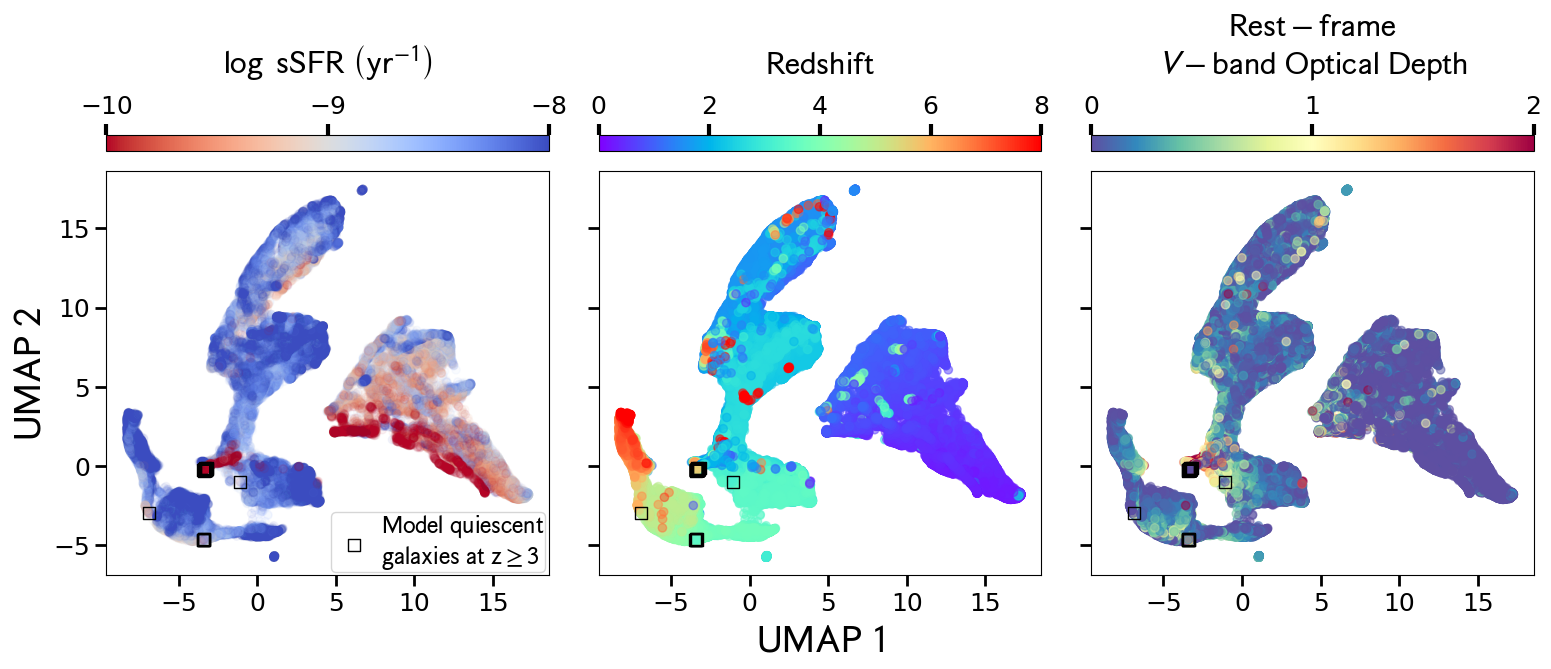

In [ ]:
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True)
fig.set_figheight(5)
fig.set_figwidth(15)
fig.tight_layout(w_pad=2.)

ax[0].scatter( u.embedding_[:,0], u.embedding_[:,1], c=ssfr_jaguar, cmap='coolwarm_r', vmin=-10, vmax=-8, alpha=0.05, label=None )
ax[0].scatter( u.embedding_[:,0][qg_z3_crit], u.embedding_[:,1][qg_z3_crit], 
            c='None', edgecolors='k', marker='s', s=75, label=r'$\rm{Model~quiescent}$' + '\n' + r'$\rm{galaxies~at~z\geq 3}$')

ax[0].legend(loc='lower right', fontsize=18, handletextpad=0.2, 
             borderaxespad=0.15, borderpad=0.01, alignment='left', 
             handlelength=1.8, labelspacing=0.2)

ax[0].tick_params(labelsize=18, length=8, width=2)
ax[0].set_xticks([-5, 0, 5, 10, 15])

ax[1].scatter( u.embedding_[:,0], u.embedding_[:,1], c=z_jaguar, cmap='rainbow', vmin=0, vmax=8, alpha=0.5 )
ax[1].scatter( u.embedding_[:,0][qg_z3_crit], u.embedding_[:,1][qg_z3_crit], 
            c='None', edgecolors='k', marker='s', s=75)
ax[1].tick_params(labelsize=18, length=8, width=2)

ax[2].scatter( u.embedding_[:,0], u.embedding_[:,1], c=tauv_jaguar, cmap='Spectral_r', vmin=0, vmax=2, alpha=0.5 )
ax[2].scatter( u.embedding_[:,0][qg_z3_crit], u.embedding_[:,1][qg_z3_crit], 
            c='None', edgecolors='k', marker='s', s=75)
ax[2].tick_params(labelsize=18, length=8, width=2)

#ax[3].scatter( u_jades[:,0], u_jades[:,1], c=data_jades[:, 1], cmap='Spectral_r', alpha=0.5, vmin=-0.5, vmax=3 )
#ax[3].scatter( u.embedding_[:,0][qg_z3_crit], u.embedding_[:,1][qg_z3_crit], 
#            c='None', edgecolors='k', marker='s', s=75)
#ax[3].tick_params(labelsize=14, length=8, width=2)

ax[1].set_xlabel(r'$\rm{UMAP~1}$', size=28)
ax[0].set_ylabel(r'$\rm{UMAP~2}$', size=28)

# colorbars
# relocation of the tick marks from:
# https://stackoverflow.com/questions/12895207/place-a-colorbar-label-above-horizontal-colorbar-instead-of-below
ssfr_plot = ax[0].scatter( u.embedding_[:,0], u.embedding_[:,1], c=ssfr_jaguar, cmap='coolwarm_r', vmin=-10, vmax=-8, alpha=1, s=0 )

div = make_axes_locatable(ax[0])
cax = div.append_axes("top", size="4%", pad='5%')
cbar = plt.colorbar(ssfr_plot, cax=cax, orientation="horizontal")
cbar.set_label(r'$\rm{\log~sSFR~\left(yr^{-1}\right)}$', size=24, labelpad=15)
cbar.ax.tick_params(labelsize=18, length=8, width=3)
cbar.ax.set_xticks([-10, -9, -8])
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

z_plot = ax[1].scatter( u.embedding_[:,0], u.embedding_[:,1], c=z_jaguar, cmap='rainbow', vmin=0, vmax=8, alpha=1., s=0 )

div = make_axes_locatable(ax[1])
cax = div.append_axes("top", size="4%", pad='5%')
cbar = plt.colorbar(z_plot, cax=cax, orientation="horizontal")
cbar.set_label(r'$\rm{Redshift}$', size=24, labelpad=15)
cbar.ax.tick_params(labelsize=18, length=8, width=3)
cbar.ax.set_xticks([0, 2, 4, 6, 8])
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

tauv_plot = ax[2].scatter( u.embedding_[:,0], u.embedding_[:,1], c=tauv_jaguar, cmap='Spectral_r', vmin=0, vmax=2, alpha=1, s=0 )

div = make_axes_locatable(ax[2])
cax = div.append_axes("top", size="4%", pad='5%')
cbar = plt.colorbar(tauv_plot, cax=cax, orientation="horizontal")
cbar.set_label(r'$\rm{Rest-frame}$' + '\n' + r'$V-\rm{band~Optical~Depth}$', size=24, labelpad=15)
cbar.ax.tick_params(labelsize=18, length=8, width=3)
cbar.ax.set_xticks([0, 1, 2])
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

#plt.savefig('./umap_jaguar_models_ssfr_z_tauv.jpg', dpi=150, format='jpg', bbox_inches='tight')

plt.show()

### load JADES photometric catalogs

The photometric catalogs released by the JADES teams are used to pre-select quiescent candidates galaxies. They can be downloaded [here](https://archive.stsci.edu/hlsp/jades). The GOODS-N catalog, v1.0, and GOODS-S catalog, V2.0, are used. 

In [10]:
jades_gds_hdu = fits.open('/apth/to/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v2.0_catalog.fits')

#print(jades_hdu.info())

# this extension contains flags
jades_gds_flag_cat = jades_gds_hdu[2].data

# this extension contains size measurements
jades_gds_size_cat = jades_gds_hdu[3].data

# this extension contains flux measurements using mosaics
# that are convolved to the same angular resolution
jades_gds_cat = jades_gds_hdu[8].data

# this extension contains the catalog of photometric redshifts
jades_gds_photo_z_cat = jades_gds_hdu[9].data

#print(jades_cat.columns)
jades_gds_hdu.close()

# print length of catalog
print(len(jades_gds_cat))

# load the JADES GOODS-N photometry catalog
jades_gdn_hdu = fits.open('/path/to/hlsp_jades_jwst_nircam_goods-n_photometry_v1.0_catalog.fits')
jades_gdn_flag_cat = jades_gdn_hdu[2].data
jades_gdn_size_cat = jades_gdn_hdu[3].data
jades_gdn_cat = jades_gdn_hdu[8].data

jades_gdn_photo_z_cat = jades_gdn_hdu[9].data
jades_gdn_hdu.close()

# print length of catalog
print(len(jades_gdn_cat))



94000
85709


### select the parent observational sample
The cell below selects galaxies in JADES according to various selection criteria (see Sec. 2.3 in de la Vega et al. 2025). Below the cell, a histogram of the signal-to-noise ratio (S/N) in the F444W bandpass is shown and the median S/N in F115W of the observational sample is printed. 

/var/folders/1_/ykm0yg054jz_l14h_2fqwfnm0000gn/T/ipykernel_7595/3633938612.py:15: RuntimeWarning: divide by zero encountered in log10
  vars()['mask_%s' % f] = -2.5 * np.log10(jades_gds_cat['%s_%s' % (f, flux_ext)] * 1e-9) + 8.9 <= mag_limit
/var/folders/1_/ykm0yg054jz_l14h_2fqwfnm0000gn/T/ipykernel_7595/3633938612.py:15: RuntimeWarning: invalid value encountered in log10
  vars()['mask_%s' % f] = -2.5 * np.log10(jades_gds_cat['%s_%s' % (f, flux_ext)] * 1e-9) + 8.9 <= mag_limit


Number of galaxies with fluxes > 0 in all filters: 22372


/var/folders/1_/ykm0yg054jz_l14h_2fqwfnm0000gn/T/ipykernel_7595/3633938612.py:48: RuntimeWarning: divide by zero encountered in log10
  vars()['mask_%s' % f] = -2.5 * np.log10(jades_gdn_cat['%s_%s' % (f, flux_ext)] * 1e-9) + 8.9 <= mag_limit
/var/folders/1_/ykm0yg054jz_l14h_2fqwfnm0000gn/T/ipykernel_7595/3633938612.py:48: RuntimeWarning: invalid value encountered in log10
  vars()['mask_%s' % f] = -2.5 * np.log10(jades_gdn_cat['%s_%s' % (f, flux_ext)] * 1e-9) + 8.9 <= mag_limit


Number of galaxies with fluxes > 0 in all filters: 21554
Shape of data matrix (43926, 7)
[0. 0. 0. 0. 0. 0. 0.]


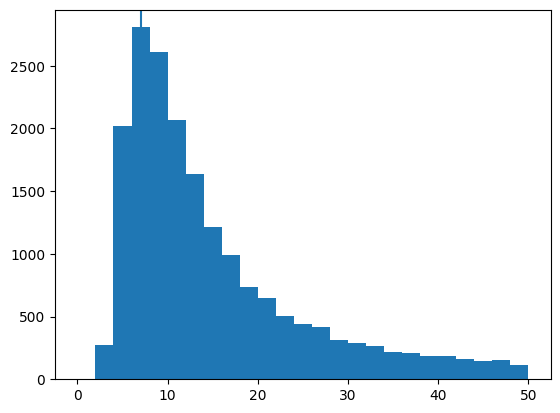

8.983269


In [11]:
flux_ext = 'KRON'

#mag_limit = 29

# create lists of arrays wherein each element evaluates to? True or False
# if a galaxy meets the condition flux > 0 in a given filter
mask_list = []

#for f in filters_select:
for f in np.unique(filter_pairs):
    # remove things with flux > 0
    #vars()['mask_%s' % f] = jades_gds_cat['%s_SEG' % f] > 0
    
    # remove things with magnitude > 29
    vars()['mask_%s' % f] = -2.5 * np.log10(jades_gds_cat['%s_%s' % (f, flux_ext)] * 1e-9) + 8.9 <= mag_limit
    
    mask_list.append(vars()['mask_%s' % f])
    
    
# add flags for stars and galaxies near stars
mask_list.append( jades_gds_flag_cat['FLAG_ST'] != 1 )
mask_list.append( jades_gds_flag_cat['FLAG_BS'] == 0 )
mask_list.append( jades_gds_flag_cat['FLAG_BN'] == 0 )

# find the elements in all of the arrays above where
# all conditions are met, i.e., at which indices
# the values of the arrays are all true
# solution from:
# https://stackoverflow.com/questions/69643397/how-do-i-combine-multiple-numpy-boolean-arrays
pos_flux_mask_gds = np.asarray(mask_list).all(0)

number_of_training_galaxies_gds = len(jades_gds_cat[pos_flux_mask_gds])

print('Number of galaxies with fluxes > 0 in all filters: %d' % number_of_training_galaxies_gds)

# GOODS-N 

# create lists of arrays wherein each element evaluates to True or False
# if a galaxy meets the condition flux > 0 in a given filter
mask_list = []

#for f in filters_select:
for f in np.unique(filter_pairs):
    # remove things with flux > 0
    #vars()['mask_%s' % f] = jades_gdn_cat['%s_SEG' % f] > 0
    
    # remove things with magnitude > 29
    vars()['mask_%s' % f] = -2.5 * np.log10(jades_gdn_cat['%s_%s' % (f, flux_ext)] * 1e-9) + 8.9 <= mag_limit
    
    mask_list.append(vars()['mask_%s' % f])
    
    
# add flags for stars and galaxies near stars
mask_list.append( jades_gdn_flag_cat['FLAG_ST'] != 1 )
mask_list.append( jades_gdn_flag_cat['FLAG_BS'] == 0 )
mask_list.append( jades_gdn_flag_cat['FLAG_BN'] == 0 )

# find the elements in all of the arrays above where
# all conditions are met, i.e., at which indices
# the values of the arrays are all true
# solution from:
# https://stackoverflow.com/questions/69643397/how-do-i-combine-multiple-numpy-boolean-arrays
pos_flux_mask_gdn = np.asarray(mask_list).all(0)

number_of_training_galaxies_gdn = len(jades_gdn_cat[pos_flux_mask_gdn])

print('Number of galaxies with fluxes > 0 in all filters: %d' % number_of_training_galaxies_gdn)

# create arrays of the colors, their means and standard deviations, and the normalized color arrays
# note that we go up to the number of filters minus one
# this is to avoid passing an index that is larger than the size
# of the filters array, and also because there are len(filters) - 1 colors

# create data list
# each array of normalized colors
# will be stored in this list
data_jades = []

#for i in range(len(filters) - 1):
#    f1, f2 = filters[i], filters[i+1]
    
# training on filter PAIRS
for i in range(len(filter_pairs)):
    f1, f2 = filter_pairs[i][0], filter_pairs[i][1]

    vars()['%s_%s_color_gds' % (f1, f2)] = -2.5 * np.log10( jades_gds_cat['%s_%s' % (f1, flux_ext)][pos_flux_mask_gds][:] / jades_gds_cat['%s_%s' % (f2, flux_ext)][pos_flux_mask_gds][:] )
    vars()['%s_%s_color_gdn' % (f1, f2)] = -2.5 * np.log10( jades_gdn_cat['%s_%s' % (f1, flux_ext)][pos_flux_mask_gdn][:] / jades_gdn_cat['%s_%s' % (f2, flux_ext)][pos_flux_mask_gdn][:] )
    
    vars()['%s_%s_color_jades' % (f1, f2)] = np.concatenate([vars()['%s_%s_color_gds' % (f1, f2)], vars()['%s_%s_color_gdn' % (f1, f2)]], axis=0)
    
    #color_means[i] = np.mean( vars()['%s_%s_color_jades' % (f1, f2)] )
    #color_stds[i] = np.std( vars()['%s_%s_color_jades' % (f1, f2)] )
    
    # array of colors normalized by the mean and standard deviation
    vars()['%s_%s_color_norm_jades' % (f1, f2)] = (vars()['%s_%s_color_jades' % (f1, f2)] - color_means[i]) / color_stds[i]
    
    # append array of normalized colors that has been transposed to data list
    data_jades.append( vars()['%s_%s_color_norm_jades' % (f1, f2)].T )
    
# turn list into array
data_jades = np.array(data_jades)

# take the transpose of the array
# to turn it into a matrix 
# with dimensions = (number of galaxies) x (number of colors)
data_jades = data_jades.T
    
print('Shape of data matrix', data_jades.shape)

# retrieve photometric redshifts
# of galaxies that meet criteria above
photo_z_gds = jades_gds_photo_z_cat['EAZY_z_a'][pos_flux_mask_gds][:]

jades_gds_id = jades_gds_cat['ID'][pos_flux_mask_gds][:]

# retrieve photometric redshifts
# of galaxies that meet criteria above
photo_z_gdn = jades_gdn_photo_z_cat['EAZY_z_a'][pos_flux_mask_gdn][:]

jades_gdn_id = jades_gdn_cat['ID'][pos_flux_mask_gdn][:]

jades_id = np.concatenate([jades_gds_id, jades_gdn_id])

# plot a histogram of the S/N in the F444W bandpass
plt.hist( jades_gds_cat['F444W_KRON'][pos_flux_mask_gds] / np.sqrt(jades_gds_cat['F444W_KRON_e'][pos_flux_mask_gds] ** 2 + jades_gds_cat['F444W_KRON_ei'][pos_flux_mask_gds] ** 2), bins=25, range=[0, 50] )
plt.axvline(7)
plt.show()

# print the median S/N of the sample in the F115W bandpass
print( np.nanmedian( jades_gds_cat['F115W_KRON'][pos_flux_mask_gds] / np.sqrt(jades_gds_cat['F115W_KRON_e'][pos_flux_mask_gds] ** 2 + jades_gds_cat['F115W_KRON_ei'][pos_flux_mask_gds] ** 2) ) )


### project the observational sample onto the UMAP projection
The next cell projects the observational sample onto the projection that was fit to the JAGUAR models above and shown in Figure 2 in de la Vega et al. (2025). 

In [14]:
u_jades = u.transform(data_jades)

### recreate Figure 3 in de la Vega et al. (2025)

170932 in sample [170932]
171147 in sample [171147]
190245 in sample [190245]
193685 in sample [193685]
194854 in sample [194854]
197911 in sample [197911]
199773 in sample [199773]
200733 in sample [200733]
201027 in sample [201027]
211628 in sample [211628]
214075 in sample [214075]
1025511 in sample [1025511]
1027461 in sample [1027461]
1072127 in sample [1072127]
1072396 in sample [1072396]
1080660 in sample [1080660]
1083288 in sample [1083288]


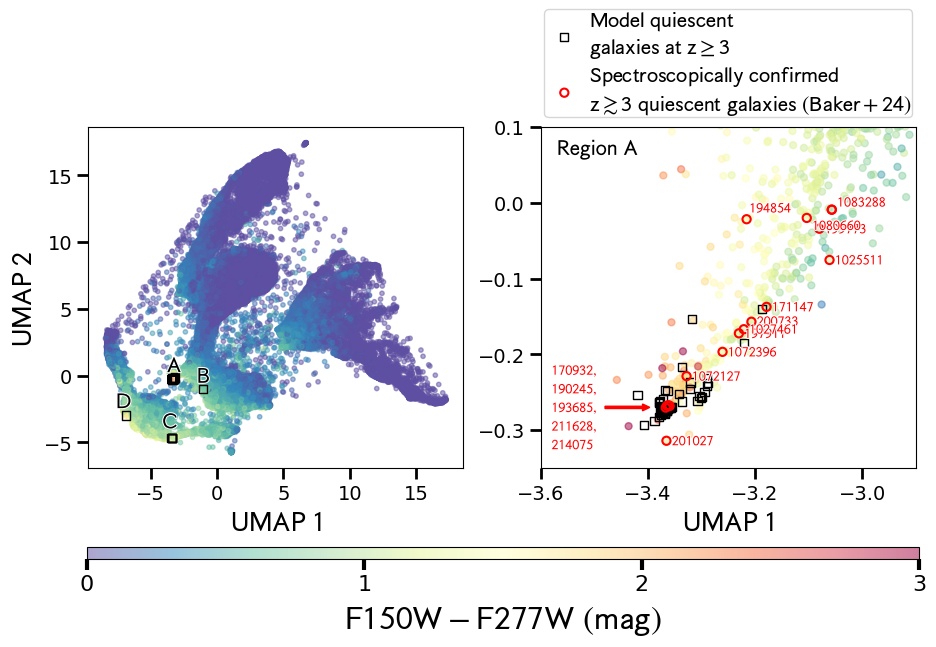

In [47]:
# IDs of galaxies in sample from Baker+24 in the JADES photometric catalogs
baker_ids_gds = np.array([170932, 171147, 190245, 193685, 194854, 197911, 199773, 200733, 201027, 211628, 214075])
baker_ids_gdn = np.array([1025511, 1088564, 1027461, 1072127, 1072396, 1080660, 1083288])

fig, ax = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(9)
fig.tight_layout(w_pad=2.5)

ax[0].scatter( u_jades[:,0], u_jades[:,1], c=data_jades[:, 3], cmap='Spectral_r', alpha=0.5, vmin=0, vmax=3, s=10 )
ax[0].scatter( u.embedding_[:,0][qg_z3_crit], u.embedding_[:,1][qg_z3_crit], 
            c='None', edgecolors='k', marker='s', s=35)

ax[1].scatter( u_jades[:,0], u_jades[:,1], c=data_jades[:, 3], cmap='Spectral_r', alpha=0.5, vmin=0, vmax=3, s=25 )
ax[1].scatter( u.embedding_[:,0][qg_z3_crit], u.embedding_[:,1][qg_z3_crit], 
            c='None', edgecolors='k', marker='s', s=35, label=r'$\rm{Model~quiescent}$' + '\n' + r'$\rm{galaxies~at~z\geq 3}$')

for i in baker_ids_gds:
    idx = np.where( jades_gds_id == i )[0]
    
    if len(idx) != 0:
        print(i, 'in sample', jades_gds_id[idx])
        
        ax[1].scatter( u_jades[:,0][idx], u_jades[:,1][idx], c='None', 
                alpha=1., edgecolors='r', marker='o', s=35, lw=1.5 )
        
        if i == 193685 or i == 214075 or i == 190245 or i == 211628 or i == 170932:
            ax[1].text(-3.58, -0.27, r'$\rm{170932,}$' + '\n' + r'$\rm{190245,}$' + '\n' + r'$\rm{193685,}$' + '\n' + r'$\rm{211628,}$' +'\n' + r'$\rm{214075}$',
                     ha='left', va='center', color='r', path_effects=[pe.withStroke(linewidth=1, foreground="w")])
        
        elif i == 194854:
            ax[1].text(u_jades[:,0][idx] + 0.005, u_jades[:,1][idx] + 0.015, r'$\rm{%d}$' % i, 
                     ha='left', va='center', color='r', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])
        
        else:
            ax[1].text(u_jades[:,0][idx] + 0.01, u_jades[:,1][idx], r'$\rm{%d}$' % i, 
                     ha='left', va='center', color='r', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])
        
    
        
        
for i in baker_ids_gdn:
    idx = np.where( jades_gdn_id == i )[0]
    
    if len(idx) != 0:
        print(i, 'in sample', jades_gdn_id[idx])
    
        ax[1].scatter( u_jades[:,0][number_of_training_galaxies_gds+idx], u_jades[:,1][number_of_training_galaxies_gds+idx], c='None', 
                alpha=1., edgecolors='r', marker='o', s=35, lw=1.5 )
        
        if i == 1080660:
            ax[1].text(u_jades[:,0][number_of_training_galaxies_gds+idx] + 0.01, 
                 u_jades[:,1][number_of_training_galaxies_gds+idx] - 0.01, 
                 r'$\rm{%d}$' % i, ha='left', va='center', color='r', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])
        
        elif i == 1083288:
            ax[1].text(u_jades[:,0][number_of_training_galaxies_gds+idx] + 0.01, 
                 u_jades[:,1][number_of_training_galaxies_gds+idx] + 0.01, 
                 r'$\rm{%d}$' % i, ha='left', va='center', color='r', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])
        else:
            ax[1].text(u_jades[:,0][number_of_training_galaxies_gds+idx] + 0.01, 
                 u_jades[:,1][number_of_training_galaxies_gds+idx], 
                 r'$\rm{%d}$' % i, ha='left', va='center', color='r', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])
    
    
ax[1].set_ylim(-0.35, 0.1)
ax[1].set_xlim(-3.6, -2.9)

ax[1].arrow(x=-3.48, y=-0.27, dx=0.07, dy=0, width=0.003, color='r')

ax[0].set_xlabel(r'$\rm{UMAP~1}$', size=20)
ax[1].set_xlabel(r'$\rm{UMAP~1}$', size=20)

ax[0].set_ylabel(r'$\rm{UMAP~2}$', size=20)

ax[0].set_xticks([-5, 0, 5, 10, 15])

ax[0].tick_params(labelsize=14, length=8, width=2)
ax[1].tick_params(labelsize=14, length=8, width=2)

# colorbar
cbar_ax = fig.add_axes([0.05, -0.13, 0.925, 0.03])

color_plot = ax[0].scatter( u_jades[:,0], u_jades[:,1], c=data_jades[:, 3], cmap='Spectral_r', alpha=0.5, vmin=0, vmax=3, s=0 )

#div = make_axes_locatable(cbar_ax)
#cax = div.append_axes("bottom", size="3%", pad='7%')
cbar = plt.colorbar(color_plot, cax=cbar_ax, orientation="horizontal")
cbar.set_label(r'$\rm{F150W-F277W~(mag)}$', size=24, labelpad=6)
cbar.ax.tick_params(labelsize=16, length=8, width=3)
cbar.ax.set_xticks([0, 1, 2, 3])

ax[1].scatter( u_jades[:,0][number_of_training_galaxies_gds+idx], u_jades[:,1][number_of_training_galaxies_gds+idx], c='None', 
                alpha=1., edgecolors='r', marker='o', s=35, lw=1.5, label=r'$\rm{Spectroscopically~confirmed}$' + '\n' + r'$\rm{z\gtrsim3~quiescent~galaxies~(Baker+24)}$' )

ax[1].legend(bbox_to_anchor=(0., 1.02, 1., .102), mode='expand', 
             fontsize=16, handletextpad=0.2, 
             borderaxespad=0.15, borderpad=0.01, alignment='left', 
             handlelength=1.8, labelspacing=0.2)

# labeling regions in left panel
ax[0].text(-3.2, 0.7, r'$\rm{A}$', size=16, 
           ha='center', va='center', color='k', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])

ax[0].text(-1, -0.1, r'$\rm{B}$', size=16, 
           ha='center', va='center', color='k', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])

ax[0].text(-3.5, -3.5, r'$\rm{C}$', size=16, 
           ha='center', va='center', color='k', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])

ax[0].text(-7, -2., r'$\rm{D}$', size=16, 
           ha='center', va='center', color='k', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])

# labeling the region in the right panel
ax[1].text(-3.57, 0.07, r'$\rm{Region~A}$', size=16, 
           va='center', color='k', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])

#plt.savefig('./umap_jades_projected_baker_qg.jpg', dpi=150, bbox_inches='tight', format='jpg')

plt.show()

### Recreate Figure 4 in de la Vega et al. (2025)
This figure shows how to pre-select a pool of candidates that contains high-redshift quiescent galaxies in two different ways. For details, see Section 5 in de la Vega et al. (2025). 

#### pre-selection based on radial distance

In [51]:
jades_qg_z3_crit_radial_cut_temp = []

for i in range(len(u.embedding_[:,0][qg_z3_crit])):
    x, y = u.embedding_[:,0][qg_z3_crit][i], u.embedding_[:,1][qg_z3_crit][i]

    idx = np.where( ( (u_jades[:,0] - x) ** 2 + (u_jades[:,1] - y) ** 2 ) <= 1. ** 2 )[0]

    if len(idx) != 0:
        for j in idx:
            jades_qg_z3_crit_radial_cut_temp.append(j)

jades_qg_z3_crit_radial_cut = np.unique(jades_qg_z3_crit_radial_cut_temp)

print(len(jades_qg_z3_crit_radial_cut))

2282


#### pre-selection based on rectangular cuts

In [50]:
jades_qg_z3_crit_straight_cut = np.where( ((u_jades[:,0] >= -3.5) & (u_jades[:,0] <= -3.1) &\
                                         (u_jades[:,1] >= -0.35) & (u_jades[:,1] <= -0.1)) |\
                                         ((u_jades[:,0] >= -4.0) & (u_jades[:,0] <= -2.8) &\
                                         (u_jades[:,1] >= -4.8) & (u_jades[:,1] <= -4.6)) )[0]

print(len(jades_qg_z3_crit_straight_cut))

247


#### load catalog of Bagpipes fits
A catalog of spectral energy distribution (SED) fits is available [here](https://github.com/alex-delavega/umap_jades_2025/tree/main). It was created using the Bayesian SED-fitting tool BAGPIPES ([Carnall et al. 2018](https://ui.adsabs.harvard.edu/abs/2018MNRAS.480.4379C/abstract)). For details, see Section 4.4 in de la Vega et al. (2025). 

In [52]:
bagpipes_fit_f = ascii.read('/path/to/bagpipes_umap_jades_2025.txt')
print(bagpipes_fit_f.colnames)

z_crit = (bagpipes_fit_f['z'] >= 3.0) & (bagpipes_fit_f['z'] <= 6.) & (bagpipes_fit_f['z_84'] <= 6.5) & (bagpipes_fit_f['z_16'] >= 2.5) &\
             (bagpipes_fit_f['SFR_100_50'] - bagpipes_fit_f['mstar_50'] <= np.log10(0.2 / (Planck18.age(bagpipes_fit_f['z']).value * 1e9)) )

print(len(bagpipes_fit_f[z_crit]))

['ID', 'field', 'umap_x', 'umap_y', 'z', 'z_type', 'z_16', 'z_84', 'ssfr_50', 'ssfr_16', 'ssfr_84', 'SFR_100_50', 'SFR_100_16', 'SFR_100_84', 'mwa_50', 'mwa_16', 'mwa_84', 'mstar_50', 'mstar_16', 'mstar_84', 'AV_50', 'AV_16', 'AV_84']
44


### recreate Figure 4 in de la Vega et al. (2025)
The cell below creates the first half of Figure 4. 

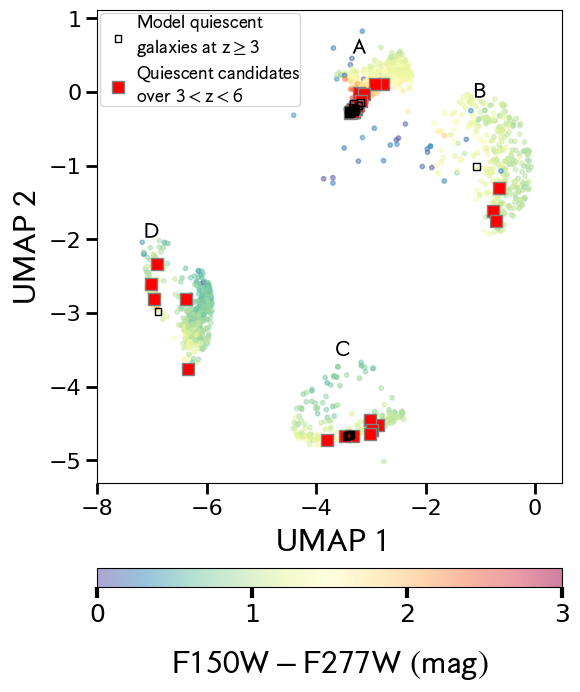

In [60]:
fig = plt.figure()
fig.set_figheight(7.5)
fig.set_figwidth(6)

umap_plot = plt.scatter( u_jades[:,0][jades_qg_z3_crit_radial_cut], u_jades[:,1][jades_qg_z3_crit_radial_cut], 
            c=data_jades[:, 1][jades_qg_z3_crit_radial_cut], cmap='Spectral_r', vmin=0, vmax=3, alpha=0.5, s=10, label=None )

plt.scatter( u.embedding_[:,0][qg_z3_crit], u.embedding_[:,1][qg_z3_crit], 
            c='None', edgecolors='k', marker='s', s=25, zorder=2,
            label=r'$\rm{Model~quiescent}$' + '\n' + r'$\rm{galaxies~at~z\geq 3}$')

for i in range(len(bagpipes_fit_f['z'][z_crit])):
    if bagpipes_fit_f['ID'][z_crit][i] in jades_id[jades_qg_z3_crit_radial_cut]:
        
    id_row = np.where(jades_id == bagpipes_fit_f['ID'][z_crit][i])[0]
        
    plt.scatter( u_jades[:,0][id_row], u_jades[:,1][id_row], 
        c='r', alpha=1, marker='s', s=75, edgecolors='gray', label=None )
    
plt.scatter( u_jades[:,0][id_row], u_jades[:,1][id_row], 
        c='r', alpha=1, marker='s', s=75, edgecolors='gray', 
        label=r'$\rm{Quiescent~candidates}$' + '\n' + r'$\rm{over~3<z<6}$')
    
plt.xlabel(r'$\rm{UMAP~1}$', size=24)
plt.ylabel(r'$\rm{UMAP~2}$', size=24)

plt.tick_params(labelsize=16, length=8, width=2)

plt.legend(loc='upper left', fontsize=14, handletextpad=0., 
             borderaxespad=0.15, borderpad=0.01, alignment='left', 
             handlelength=1.8, labelspacing=0.2)

plt.xlim(-8, 0.5)

# label regions
plt.text(-3.2, 0.6, r'$\rm{A}$', size=16, 
           ha='center', va='center', color='k', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])

plt.text(-1, -0., r'$\rm{B}$', size=16, 
           ha='center', va='center', color='k', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])

plt.text(-3.5, -3.5, r'$\rm{C}$', size=16, 
           ha='center', va='center', color='k', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])

plt.text(-7, -1.9, r'$\rm{D}$', size=16, 
           ha='center', va='center', color='k', path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])

# colorbar
div = make_axes_locatable(plt.gca())
cax = div.append_axes("bottom", size="4%", pad='18%')
cbar = plt.colorbar(umap_plot, cax=cax, orientation="horizontal")
cbar.set_label(r'$\rm{F150W-F277W~(mag)}$', size=24, labelpad=15)
cbar.ax.tick_params(labelsize=18, length=8, width=3)
cbar.ax.set_xticks([0, 1, 2, 3])

#plt.savefig('./umap_radial_selection_big_picture.jpg', format='jpg', dpi=150, bbox_inches='tight')

plt.show()

The cell below creates the second half of Figure 4.

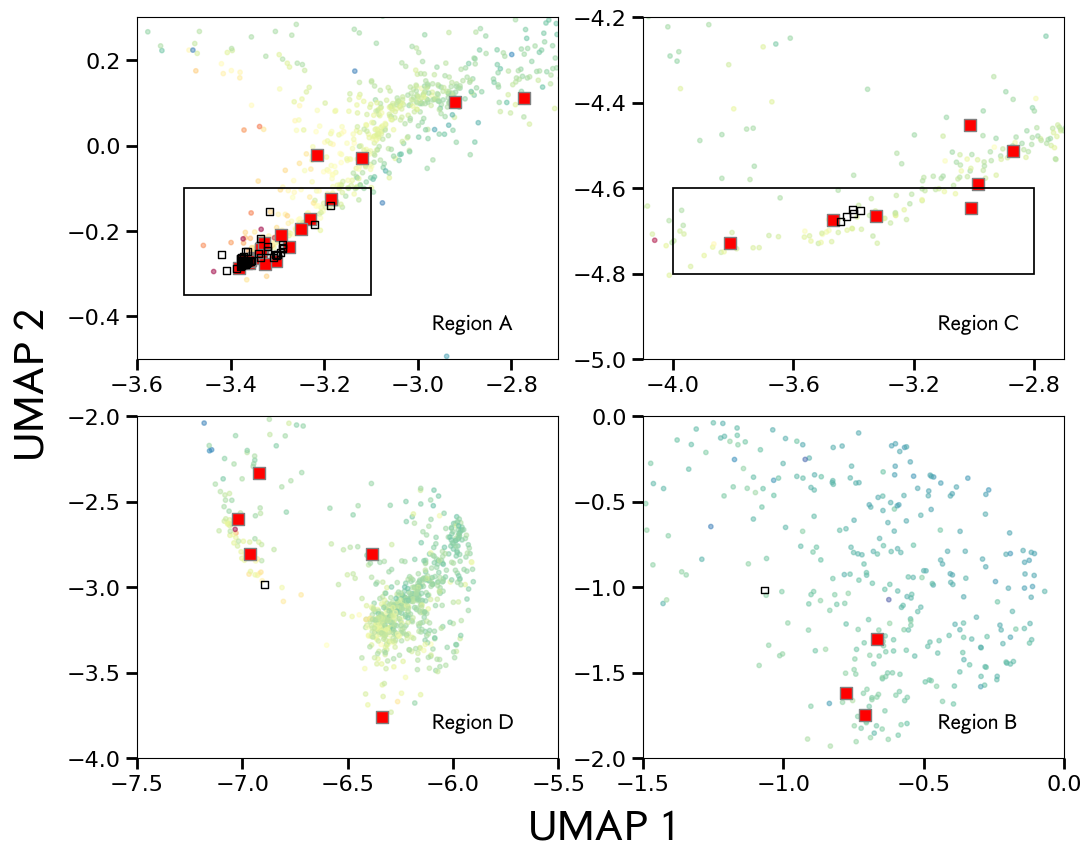

In [69]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(10)
fig.tight_layout(w_pad=3., h_pad=2.)

[a.scatter( u_jades[:,0][jades_qg_z3_crit_radial_cut], u_jades[:,1][jades_qg_z3_crit_radial_cut], 
            c=data_jades[:, 3][jades_qg_z3_crit_radial_cut], cmap='Spectral_r', vmin=0, vmax=3, alpha=0.5, s=10, zorder=0 ) for a in ax[0,:]]

[a.scatter( u_jades[:,0][jades_qg_z3_crit_radial_cut], u_jades[:,1][jades_qg_z3_crit_radial_cut], 
            c=data_jades[:, 3][jades_qg_z3_crit_radial_cut], cmap='Spectral_r', vmin=0, vmax=3, alpha=0.5, s=10, zorder=0 ) for a in ax[1,:]]

[a.scatter( u.embedding_[:,0][qg_z3_crit], u.embedding_[:,1][qg_z3_crit], 
            c='None', edgecolors='k', marker='s', s=25, zorder=2) for a in ax[0,:]]

[a.scatter( u.embedding_[:,0][qg_z3_crit], u.embedding_[:,1][qg_z3_crit], 
            c='None', edgecolors='k', marker='s', s=25, zorder=2) for a in ax[1,:]]

ax[0,0].set_xlim(-3.6, -2.7)
ax[0,0].set_ylim(-0.5, 0.3)
ax[0,0].tick_params(labelsize=16, length=8, width=2)

ax[0,1].set_xlim(-4.1, -2.7)
ax[0,1].set_ylim(-5, -4.2)
ax[0,1].tick_params(labelsize=16, length=8, width=2)

ax[1,0].set_xlim(-7.5, -5.5)
ax[1,0].set_ylim(-4, -2)
ax[1,0].tick_params(labelsize=16, length=8, width=2)

ax[1,1].set_xlim(-1.5, 0)
ax[1,1].set_ylim(-2, 0)
ax[1,1].tick_params(labelsize=16, length=8, width=2)

# quiescent galaxy candidates
for i in range(len(bagpipes_fit_f['z'][z_crit])):
    id_row = np.where(jades_id == bagpipes_fit_f['ID'][z_crit][i])[0]
        
    ax[0,0].scatter( u_jades[:,0][id_row], u_jades[:,1][id_row], 
        c='r', edgecolors='gray', alpha=1, marker='s', s=75, zorder=1 )
    
    ax[0,1].scatter( u_jades[:,0][id_row], u_jades[:,1][id_row], 
        c='r', edgecolors='gray', alpha=1, marker='s', s=75, zorder=1 )
    
    ax[1,0].scatter( u_jades[:,0][id_row], u_jades[:,1][id_row], 
        c='r', edgecolors='gray', alpha=1, marker='s', s=75, zorder=1 )
    
    ax[1,1].scatter( u_jades[:,0][id_row], u_jades[:,1][id_row], 
        c='r', edgecolors='gray', alpha=1, marker='s', s=75, zorder=1 )
    
# np.where( ((u_jades[:,0] >= -3.5) & (u_jades[:,0] <= -3.1) &\
#            (u_jades[:,1] >= -0.35) & (u_jades[:,1] <= -0.1)) |\
#            ((u_jades[:,0] >= -4.0) & (u_jades[:,0] <= -2.8) &\
#            (u_jades[:,1] >= -4.8) & (u_jades[:,1] <= -4.6)) )[0]
    
rec1 = plt.Rectangle( ( -3.5, -0.35 ), 
                    ( 0.4 ), 
                    ( 0.25 ), 
                    fill=False, lw=1.25, linestyle="-", color='k')

rec1 = ax[0,0].add_patch(rec1)
rec1.set_clip_on(False)

rec2 = plt.Rectangle( ( -4., -4.8 ), 
                    ( 1.2 ), 
                    ( 0.2 ), 
                    fill=False, lw=1.25, linestyle="-", color='k')

rec2 = ax[0,1].add_patch(rec2)
rec2.set_clip_on(False)

ax[0,0].text(-0.25, -0.075, r'$\rm{UMAP~2}$', size=32, ha='center', va='center', rotation=90, transform=ax[0,0].transAxes)
ax[1,0].text(1.1, -0.2, r'$\rm{UMAP~1}$', size=32, ha='center', va='center', transform=ax[1,0].transAxes)

ax[0,1].set_xticks([-4, -3.6, -3.2, -2.8])

ax[1,1].set_xticks([-1.5, -1.0, -0.5, 0.0])

# labeling the regions in the right panel
ax[0,0].text(0.7, 0.1, r'$\rm{Region~A}$', size=16, 
           va='center', color='k', transform=ax[0,0].transAxes, 
             path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])

ax[0,1].text(0.7, 0.1, r'$\rm{Region~C}$', size=16, 
           va='center', color='k', transform=ax[0,1].transAxes, 
             path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])

ax[1,0].text(0.7, 0.1, r'$\rm{Region~D}$', size=16, 
           va='center', color='k', transform=ax[1,0].transAxes, 
             path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])

ax[1,1].text(0.7, 0.1, r'$\rm{Region~B}$', size=16, 
           va='center', color='k', transform=ax[1,1].transAxes, 
             path_effects=[pe.withStroke(linewidth=1.5, foreground="w")])

#plt.savefig('./umap_radial_selection_zoom.jpg', format='jpg', dpi=150, bbox_inches='tight')

plt.show()